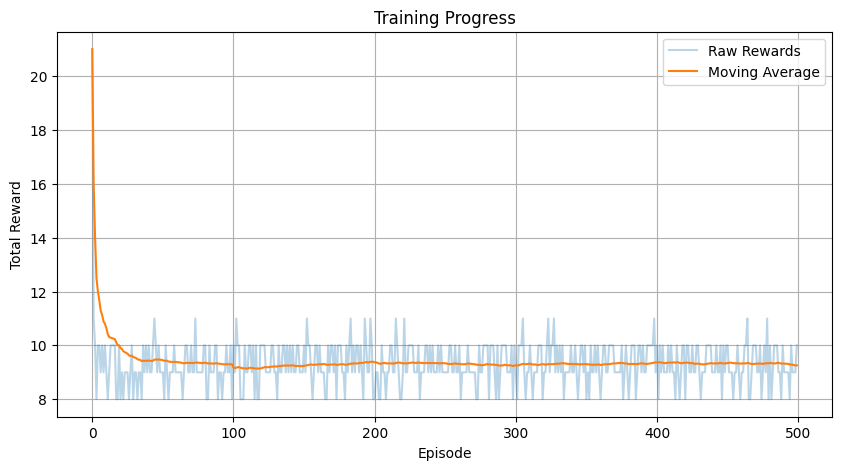

In [7]:
import sys
sys.path.append('..')

import gym
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time  # 添加这行来控制显示速度

from models.policy_network import PolicyNetwork
from models.utils import ExperienceBuffer, plot_training_results

# 创建环境
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]  # 4 （状态空间维度 = 4 (小车位置、速度、杆子角度、角速度)）
output_dim = env.action_space.n  # 2 动作空间维度 = 2 (左推或右推)

# 创建策略网络和优化器
policy = PolicyNetwork(input_dim, output_dim) # 策略网络：状态->动作概率
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# 创建经验缓冲区
buffer = ExperienceBuffer()

# 训练参数
num_episodes = 500
max_steps = 500
episode_rewards = []

# 训练循环
for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    buffer.reset()
    
    # 收集一个episode的经验
    for step in range(max_steps):
        action, log_prob = policy.select_action(state)
         # log_prob 是选择该动作的对数概率，用于后续计算策略梯度
        try:
            result = env.step(action)
            if len(result) == 5:
                next_state, reward, terminated, truncated, _ = result
                done = bool(terminated) or bool(truncated)
            else:
                next_state, reward, done, _ = result
                done = bool(done)
        except Exception as e:
            print(f"Error during step: {e}")
            break
        
        buffer.add(reward, log_prob)
        episode_reward += reward
        
        if done:
            break
            
        state = next_state
    
    # 只在有足够数据时更新策略
    if len(buffer.rewards) > 0:
        optimizer.zero_grad()
        loss = buffer.get_policy_loss()
        loss.backward()
        optimizer.step()
    
    episode_rewards.append(episode_reward)
    
    # 每10个episode打印一次平均奖励
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f'Episode {episode + 1}, Average Reward: {avg_reward:.2f}')
        
        # 绘制实时训练进度
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        moving_averages = plot_training_results(episode_rewards)
        plt.plot(episode_rewards, alpha=0.3, label='Raw Rewards')
        plt.plot(moving_averages, label='Moving Average')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.show()


In [8]:
episode_rewards

[21.0,
 11.0,
 10.0,
 8.0,
 10.0,
 10.0,
 9.0,
 10.0,
 9.0,
 10.0,
 9.0,
 8.0,
 9.0,
 10.0,
 10.0,
 10.0,
 10.0,
 8.0,
 8.0,
 10.0,
 8.0,
 9.0,
 8.0,
 9.0,
 9.0,
 9.0,
 8.0,
 9.0,
 10.0,
 8.0,
 9.0,
 9.0,
 8.0,
 9.0,
 9.0,
 8.0,
 10.0,
 9.0,
 10.0,
 9.0,
 10.0,
 9.0,
 9.0,
 10.0,
 11.0,
 10.0,
 9.0,
 10.0,
 9.0,
 9.0,
 9.0,
 8.0,
 10.0,
 9.0,
 8.0,
 9.0,
 9.0,
 9.0,
 10.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 8.0,
 9.0,
 10.0,
 10.0,
 9.0,
 9.0,
 10.0,
 9.0,
 9.0,
 11.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 8.0,
 8.0,
 10.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 8.0,
 9.0,
 9.0,
 8.0,
 9.0,
 9.0,
 10.0,
 9.0,
 9.0,
 10.0,
 8.0,
 10.0,
 9.0,
 11.0,
 10.0,
 10.0,
 8.0,
 8.0,
 8.0,
 10.0,
 9.0,
 9.0,
 10.0,
 10.0,
 9.0,
 10.0,
 8.0,
 10.0,
 8.0,
 8.0,
 10.0,
 10.0,
 10.0,
 10.0,
 9.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 9.0,
 9.0,
 8.0,
 10.0,
 9.0,
 9.0,
 10.0,
 10.0,
 9.0,
 10.0,
 9.0,
 10.0,
 9.0,
 10.0,
 9.0,
 9.0,
 10.0,
 10.0,
 9.0,
 9.0,
 9.0,
 10.0,
 9.0,
 11.0,
 10.0,
 10.0,
 9.0,
 8.0

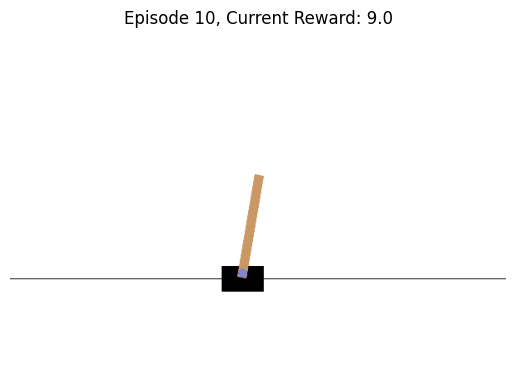

Episode 10 finished with reward 10.0


In [3]:
from models.utils import show_agent
# 展示训练结果
show_agent(env, policy,10)